В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
%load_ext autoreload
%autoreload 2

from process_bank_churn import preprocess_data, preprocess_new_data

In [3]:
data_path = r'C:\Users\olha.koltun\OneDrive - Trico\ML Course\data\bank-customer-churn-prediction-dlu-course-c-2'
raw_df = pd.read_csv(os.path.join(data_path, 'train.csv'))

data = preprocess_data(raw_df, scale_numeric=False)

In [4]:
X_train = data['X_train']
train_targets = data['train_targets']
X_val = data['X_val']
val_targets = data['val_targets']
input_cols = data['input_cols']
scaler = data['scaler'],
encoder = data['encoder']

In [5]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,682.0,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,1.0,0.0,0.0,0.0,1.0
10393,684.0,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,1.0,0.0,0.0,1.0,0.0
80,705.0,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0,1.0,0.0,0.0,1.0
3365,669.0,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0,0.0,1.0,0.0,1.0
12236,707.0,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,1.0,0.0,0.0,0.0,1.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [6]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [7]:
def evaluate_auroc(model, X_train, X_val, train_targets, val_targets):
    # Get predicted probabilities
    train_probs = model.predict_proba(X_train)[:, 1]
    val_probs = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC-ROC scores
    train_auc = roc_auc_score(train_targets, train_probs)
    val_auc = roc_auc_score(val_targets, val_probs)
    
    # Print results
    print(f"Train AUC-ROC: {train_auc:.4f}")
    print(f"Validation AUC-ROC: {val_auc:.4f}")
    
    return {"train_auc": train_auc, "val_auc": val_auc}

In [8]:
evaluate_auroc(knn, X_train, X_val, train_targets, val_targets)

Train AUC-ROC: 0.8238
Validation AUC-ROC: 0.5734


{'train_auc': 0.8237648065802492, 'val_auc': 0.5734031826599904}

### Аналіз результатів:
- Висока точність на тренувальному наборі (**0.8238**) свідчить про те, що модель добре адаптується до навчальних даних.
- Низька точність на валідаційному наборі (**0.5734**) вказує на проблему перенавчання (overfitting) – модель добре запам’ятала тренувальні приклади, але погано узагальнює нові дані.

### Висновок:
Модель демонструє високу варіативність (`high variance`), що є типовою проблемою для KNN при малих значеннях `k`. 

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

Після успішного завершення пошуку оптимального гіперпараметра
- виведіть найкраще значення параметра
- збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
- оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
- зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [9]:
params_knn = {'n_neighbors': np.arange(1, 50)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [10]:
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_)

{'n_neighbors': 44}


In [11]:
evaluate_auroc(knn_best, X_train, X_val, train_targets, val_targets)

Train AUC-ROC: 0.6606
Validation AUC-ROC: 0.6194


{'train_auc': 0.6605853413763019, 'val_auc': 0.6193881610535702}

### Аналіз результатів:
- KNN після оптимізації (`k=44`) зменшив перенавчання, покращивши узагальнення (Validation AUC-ROC: 0.5734 → 0.6194). Проте загальна точність все ще низька, а модель не демонструє стабільних результатів.
- Дерево рішень з `max_depth=5` значно перевершує KNN (Validation AUC-ROC: 0.9219), забезпечуючи кращий баланс між навчанням і тестуванням.

### Висновок:
- Оптимізований KNN показав кращі результати, ніж початковий варіант, але в цілому якість моделі все ще залишає бажати кращого.
- Дерево рішень демонструє більш збалансовану модель, яка добре працює як на тренувальних, так і на валідаційних даних.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [13]:
dt = DecisionTreeClassifier(random_state=42)
params_dt = {
    'max_depth': np.arange(1, 20, 2), 
    'max_leaf_nodes': np.arange(2, 11, 1)
}
dt_gs = GridSearchCV(dt, params_dt, cv=3, scoring='roc_auc')

In [14]:
%%time
dt_gs.fit(X_train, train_targets)

CPU times: total: 2.77 s
Wall time: 2.78 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='roc_auc')

In [15]:
dt_best = dt_gs.best_estimator_

print(dt_gs.best_params_)

{'max_depth': 5, 'max_leaf_nodes': 10}


In [16]:
evaluate_auroc(dt_best, X_train, X_val, train_targets, val_targets)

Train AUC-ROC: 0.9015
Validation AUC-ROC: 0.9002


{'train_auc': 0.9014754782174744, 'val_auc': 0.9002184649152891}

### Аналіз результатів:
1. Оптимальна модель з GridSearchCV
- Найкращі параметри: `max_depth=5`, `max_leaf_nodes=10`
- Train AUC-ROC: **0.9015**
- Validation AUC-ROC: **0.9002**
2. Порівняння з моделлю, знайденою вручну
- У випадку ручного підбіру максимальний AUC-ROC на валідації був **0.9219** при `max_depth=5`.
- Нова модель має трохи нижчий AUC-ROC (**0.9002**), але все ще дуже високий і стабільний.

### Висновок:
- Модель, знайдена GridSearchCV, показує стабільні результати на тренувальних і валідаційних даних, що вказує на гарний баланс між навчанням і узагальненням.
- Проте вона трохи поступається моделі, знайденій вручну (**0.9002** vs. **0.9219**), можливо, через обмеження `max_leaf_nodes`.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [17]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
dt_random_search = RandomizedSearchCV(dt, params_dt, n_iter=40, cv=cv_strategy, scoring='roc_auc', random_state=42)

In [18]:
%%time
dt_random_search.fit(X_train, train_targets)

CPU times: total: 703 ms
Wall time: 715 ms


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [19]:
dt_random_search_best = dt_random_search.best_estimator_

print(dt_random_search.best_params_)

{'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}


In [20]:
evaluate_auroc(dt_random_search_best, X_train, X_val, train_targets, val_targets)

Train AUC-ROC: 0.9169
Validation AUC-ROC: 0.9166


{'train_auc': 0.9169275635848141, 'val_auc': 0.9166204815145071}

### Аналіз результатів:
1. Оптимальна модель після `RandomizedSearchCV`
- Train AUC-ROC: **0.9169**
- Validation AUC-ROC: **0.9166**
2. Порівняння з `GridSearchCV` (`dt_best`)
- У GridSearchCV:
    - Train AUC-ROC: **0.9015**
    - Validation AUC-ROC: **0.9002**
- У RandomizedSearchCV:
    - Validation AUC-ROC вище (**0.9166** vs. **0.9002**), що вказує на кращу узагальнюючу здатність моделі.
    - `max_depth=16` замість `5` → модель стала глибшою, здатною уловлювати складніші закономірності.
    - `criterion='entropy'` замість `gini` → можливо, більш гнучке розбиття вузлів допомогло отримати кращий результат.
    - `min_samples_split=20`, що запобігає надмірному розгалуженню дерева.
3. Швидкість виконання:
- `RandomizedSearchCV` завершився в 3.9 раза швидше (`715 ms` vs. `2.78 s` у `GridSearchCV`).
- Це пояснюється тим, що `GridSearchCV` перебирає всі можливі комбінації параметрів, тоді як `RandomizedSearchCV` обирає **40 випадкових варіантів**, що значно скорочує час.

### Висновок:
- Модель після `RandomizedSearchCV` виявилася кращою – вона має вищу точність та швидше знаходить оптимальні параметри.
- Головні переваги RandomizedSearchCV:
    - Швидше виконується (**~3.9** раза швидше, ніж `GridSearchCV`).
    - Дає кращу узагальнюючу здатність моделі.
    - Дозволяє ефективно досліджувати велику кількість гіперпараметрів без повного перебору всіх можливих комбінацій.
- Якщо обчислювальні ресурси обмежені або потрібно швидко знайти хорошу модель, `RandomizedSearchCV` є більш ефективним вибором, ніж `GridSearchCV`.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [21]:
new_data = pd.read_csv(os.path.join(data_path, 'test.csv'))
new_data = new_data.drop(columns=['CustomerId', 'Surname'])

preprocessed_new_data = preprocess_new_data(new_data, encoder)
new_input_cols = [col for col in preprocessed_new_data.columns if col != 'id']

preprocessed_new_data['Exited'] = dt_random_search_best.predict_proba(preprocessed_new_data[new_input_cols])[:, 1]

preprocessed_new_data.head()

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,584.0,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0,1.0,0.0,0.0,1.0,0.237911
1,15001,551.0,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,1.0,0.0,0.0,0.0,1.0,0.012115
2,15002,706.0,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,1.0,0.0,0.0,0.0,1.0,0.203947
3,15003,717.0,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0,0.0,1.0,0.0,1.0,0.569848
4,15004,592.0,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0,0.0,1.0,0.0,1.0,0.082171


In [22]:
submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

submission_df['Exited'] = preprocessed_new_data.set_index('id').loc[submission_df['id'], 'Exited'].values

print('First 5 rows of the submission file:')
print(submission_df.head())

submission_df.to_csv(os.path.join(data_path, 'submission_log_reg.csv'), index=False)
print('Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!')


First 5 rows of the submission file:
      id    Exited
0  15000  0.237911
1  15001  0.012115
2  15002  0.203947
3  15003  0.569848
4  15004  0.082171
Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!


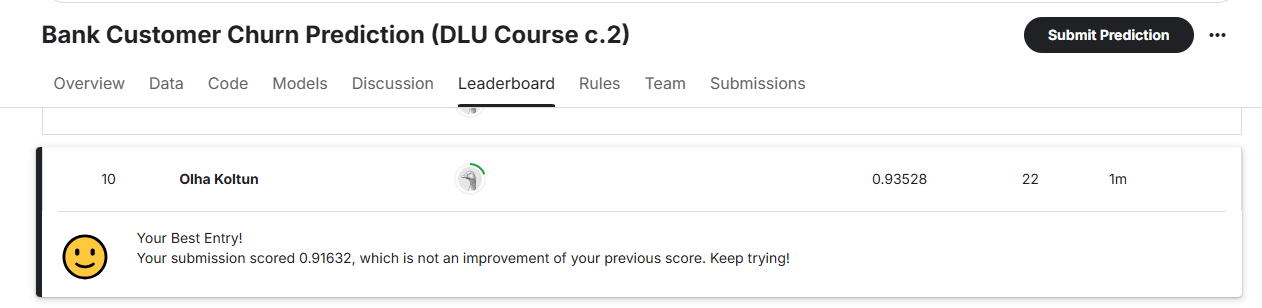